# NL Grids
NL Grids genereert ruimtelijk complementaire hexagon grids gebaseerd op en geldig voor het Rijksdriehoekstelsel.

## Versie
2.1   
Voor de nieuwste versie zie [GitHub](https://github.com/bleutzinn/NL-Grids)

## Documentatie
Zie de [ReadMe](https://github.com/bleutzinn/NL-Grids#readme)

## Copyright
Ron Wardenier, ron@rwgc.nl

Start
Opvragen van provincie Noord-Brabant
Opvragen van provincie Limburg
Genereren van cellen gestart
Aantal cellen: 221
Genereren klaar
Clip gestart
Clip klaar
Aantal cellen in grid: 108
Plotten gestart


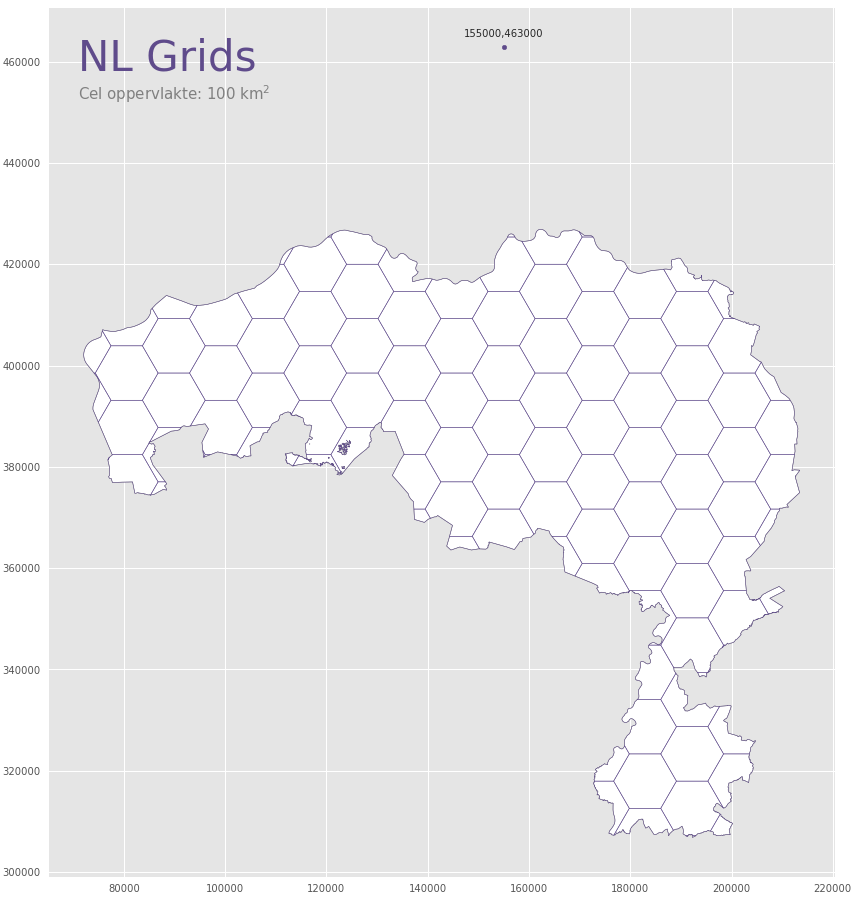

Plotten klaar
Export als dataset gestart
Grid dataset GeoPackage: nlgrid_Noord-Brabant_Limburg_100km2.gpkg
Export klaar
Run time: 2.8 seconds
Klaar


In [5]:
########################################################################################################################

# Oppervlakte eenheid ('m2', 'ha' of 'km2')
eenheid = 'km2'

# Oppervlakte per cel of hexagon (geheel of gebroken getal)
oppervlakte = 100

# Grid gebied (naam van gebied conform WFS Bestuurlijke gebieden)
gebied = 'Provincie Noord-Brabant, provincie Limburg'

# Type intersect met gebied ('clip' of 'overlay')
intersect = 'clip'

# Export format ('gpkg' of 'gml')
export = 'gpkg'


########################################################################################################################

opp_factor = 0
if eenheid == 'm2':
    opp_factor = 1
elif eenheid == 'ha':
    opp_factor = 10000
elif eenheid == 'km2':
    opp_factor = 1000000
else:
    print('Ongeldige oppervlakte eenheid opgegeven')

    
if opp_factor > 0:
    
    print("Start")
    
    # Initialisatie

    %matplotlib inline
    import time
    import math
    import geopandas as gpd
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from shapely.geometry import Point, Polygon
    from shapely.affinity import translate
    from shapely.ops import unary_union
    from requests import Request
    
    start = time.perf_counter()

    # RD-stelsel oorsprong
    rdx0 = 155000
    rdy0 = 463000
    oorsprong = gpd.GeoDataFrame([[Point([rdx0, rdy0])]],columns=['geometry'])

    # Cel oppervlakte in vierkante meters
    cel_opp = oppervlakte * opp_factor

    # Lengte van een hexagon zijde
    l = math.sqrt((2 * cel_opp) / (3 * math.sqrt(3)))

    # Bepaal de hexagon middelpunt afstanden
    hs = 1.5 * l
    vs = math.sqrt(3) * l

    # Maak hexagon met als middelpunt (155000 463000)
    p = Polygon([[rdx0 + math.cos(math.radians(angle)) * l,
                  rdy0 + math.sin(math.radians(angle)) * l]
                 for angle in range(0, 360, 60)])
    
    # Download gebieden
    
    wfs_url = 'https://service.pdok.nl/kadaster/bestuurlijkegebieden/wfs/v1_0'
    service = 'WFS'
    version = '2.0.0'
    request = 'GetFeature'
    method  = 'GET'
    
    if gebied == 'Nederland':

        print("Opvragen van Nederland")
        namen = [gebied]
        layer = 'bestuurlijkegebieden:Landgebied'
        params = dict(service=service, version=version, request=request, typeName=layer)
        qry = Request(method, wfs_url, params=params).prepare().url
        gebieden_polygons = gpd.read_file(qry)['geometry']
        
    else:

        namen = []
        lijst = {'Gemeenten': [], 'Provincies': []}
        for gebied in gebied.split(','):
            niveau, naam = gebied.strip().split(' ', 1)

            naam = naam.strip()
            namen.append(naam)
            if niveau.lower().strip() == 'gemeente':
                lijst['Gemeenten'].append(naam)
            if niveau.lower().strip() == 'provincie':
                lijst['Provincies'].append(naam)

        gebieden_polygons = gpd.GeoSeries([])
        
        for indeling in lijst:
            layer = 'bestuurlijkegebieden:' + indeling[:-1] + 'gebied'

            naam_filter = ''
            for naam in lijst[indeling]:
                print("Opvragen van {} {}".format(indeling[:-1].lower(), naam))
                naam_filter = naam_filter + '<PropertyIsEqualTo><PropertyName>naam</PropertyName><Literal>'+naam+'</Literal></PropertyIsEqualTo>'
        
            if len(lijst[indeling]) > 0:
                if len(lijst[indeling]) > 1:
                    qfilter = '<Filter><OR>' + naam_filter + '</OR></Filter>'
                else:
                    qfilter = '<Filter>' + naam_filter + '</Filter>'

                params = dict(service=service, version=version, request=request, typeName=layer, filter=qfilter)
                qry = Request(method, wfs_url, params=params).prepare().url
                gebieden_polygons = gebieden_polygons.geometry.append(gpd.read_file(qry)['geometry'])
                
        gebieden_polygons = gpd.GeoSeries(unary_union(gebieden_polygons))
    
    filename = "nlgrid_{}_{}{}".format('_'.join(namen), str(oppervlakte), eenheid)
    layer_name = "nlgrid_{}_{}{}".format('_'.join(namen), str(oppervlakte), eenheid)
        
    minx, miny, maxx, maxy = gebieden_polygons.total_bounds

    nminx = math.floor((minx - rdx0) / hs)
    nmaxx = math.floor((maxx - rdx0) / hs) + 1
    nminy = math.floor((miny - rdy0) / vs)
    nmaxy = math.floor((maxy - rdy0) / vs) + 1

    dekking_column_name = 'dekkingpct'
    index_column_name = 'q_r'

    polygons = []
    qr_attributes = []
    q = []
    r = []

    vshift = nminx % 2 == 0

    print("Genereren van cellen gestart")
    
    for x in range(nminx, nmaxx + 1):
        vshift = not vshift
        for y in range(nminy, nmaxy + 1):
            polygons.append(translate(p, x * hs, y * vs + vshift * 0.5 * vs))
            qr_attributes.append(str(x) + ' ' + str(y * 2 + vshift))
            q.append(x)
            r.append(y * 2 + vshift)
    
    print("Aantal cellen: {}".format(len(polygons)))
    print("Genereren klaar")

    grid = gpd.GeoDataFrame({'geometry':polygons})
    grid.crs = "EPSG:28992"
    grid[index_column_name] = qr_attributes
    grid[dekking_column_name] = 100
    grid['q'] = q
    grid['r'] = r
    
    gebieden_polygons.crs = "EPSG:28992"
    
    if intersect.lower() == 'clip':
    
        print("Clip gestart")

        nlgrid = gpd.clip(grid, gebieden_polygons).dissolve(index_column_name)
        nlgrid[dekking_column_name] = round(nlgrid.area * 100 / cel_opp, 1)
        nlgrid.sort_values(by=['q','r'], inplace=True)
        
        print("Clip klaar")  
        
    else:
    
        print("Overlay gestart")

        nlgrid = gpd.overlay(grid,
                             gpd.GeoDataFrame({'geometry':gebieden_polygons}),
                             how='intersection').dissolve(index_column_name).reset_index()
        cond = ~grid[index_column_name].isin(nlgrid[index_column_name])
        nlgrid = grid.drop(grid[cond].index)
        nlgrid[dekking_column_name] = round(nlgrid.area * 100 / cel_opp, 1)

        print("Overlay klaar")
            
    nlgrid.drop(columns=['q','r'], inplace=True)
    nlgrid.reset_index(inplace=True)
    
    print("Aantal cellen in grid: {}".format(len(nlgrid)))

    print("Plotten gestart")
    
    figsize = (16,16)
    with plt.style.context(('seaborn', 'ggplot')):
        base = gebieden_polygons.plot(figsize=figsize, color='white', edgecolor='grey')
        dekking = nlgrid.plot(ax=base, figsize=figsize, color='none', edgecolor='#5f4b8b')
        rd00 = oorsprong.plot(ax=base, figsize=figsize, marker='o', markersize=20, color='#5f4b8b')
        label = "{},{}".format(rdx0, rdy0)

        plt.annotate(label,
                     (rdx0,rdy0),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
        
        plt.annotate('NL Grids', xy=(0, 1), xycoords='axes fraction',
             xytext=(30, -30), textcoords='offset points',
             ha="left", va="top", fontsize=42, color='#5f4b8b')
    
        plt.annotate("Cel oppervlakte: {} {}".format(str(oppervlakte), 'ha' if eenheid == 'ha' else 'km$^2$'), xy=(0, 1), xycoords='axes fraction',
             xytext=(30, -76), textcoords='offset points',
             ha="left", va="top", fontsize=15, color='grey')
    
    plt.savefig(filename + '.png')
    plt.show()

    print("Plotten klaar")
    
    print("Export als dataset gestart")
    
    # Bewaar grid in opgegeven format
    filename = filename + '.'+ export.lower()
    if export.lower() == 'gpkg':
        nlgrid.to_file(filename, layer=layer_name, driver="GPKG")
        print("Grid dataset GeoPackage: {}".format(filename))
        print("Export klaar")
    else:
        if export.lower() == 'gml':
            nlgrid.to_file(filename, layer=layer_name, driver='GML')
            print("Grid dataset GML file: {}".format(filename))
            print("Export klaar")

    print(f"Run time: {time.perf_counter() - start:0.1f} seconds")
    print("Klaar")